# Deepfake Image Detection

Autori: Bucă Mihnea-Vicențiu; Căpatână Răzvan-Nicolae; Luculescu Teodor


## Model attribution

In this part we investigate whether we can identify the generative model that has produced a particular image. We formulate this task as a multiclass classification task, where the input is an image and the output is one of the five classes: “ldm”, “lama”, “pluralistic”, “repaint”, “real”. Experiment with the same methods as for the first task. Report the overall accuracy and the per class accuracy. Display a TSNE plot of the features color coded by the five classes.

### Data

The dataset can be downloaded from [here](https://drive.google.com/file/d/1NfLX9bZtOY8dO_yj3cU7pEHGmqItqjg2/view). It contains real images from the CelebAHQ dataset and locally manipulated images produced by four generators: [LDM](https://github.com/CompVis/latent-diffusion), [Pluralistic](https://github.com/lyndonzheng/Pluralistic-Inpainting), [LAMA](https://github.com/advimman/lama), [Repaint](https://github.com/andreas128/RePaint). You can read more about how this dataset was produced in Section 3.3 of the following paper:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will extract the data for each model

In [3]:
import zipfile
import os

# path to the zip file
zip_file_path = 'drive/MyDrive/Proiect DeepLearning/DeepFMI_local_data.zip'

# the paths to the datasets within the zip file
dataset_paths = [
    'FMI_local_data/celebhq_real_data',
    'FMI_local_data/lama',
    'FMI_local_data/ldm',
    'FMI_local_data/pluralistic',
    'FMI_local_data/repaint'
]

# create a ZipFile object
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Iterate through the dataset paths
    for dataset_path in dataset_paths:
         zip_ref.extractall(members=[
            name for name in zip_ref.namelist()
            if name.startswith(dataset_path)
        ], path='/content/')  # Extract to the '/content/' directory


In [4]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-0oauavi2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-0oauavi2
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-bep61u96
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-bep61u96
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=401c28e72637267517ed4e4076c8302e3d41c2f54a58cddfa539570b3e02b2e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-qnoutrvo/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


## Training Models

In [6]:
# important libraries
import torch
import glob
import pandas as pd
import torch.nn as nn
import torch.optim as optim

import numpy as np

import timm
import clip
import torch.nn.functional as F
import torch.optim as optim

from torch.optim import AdamW
from IPython.display import display, Markdown
from sklearn.metrics import average_precision_score
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.models as models
# from sam2.build_sam import build_sam2
# from sam2.sam2_image_predictor import SAM2ImagePredictor
from segment_anything import sam_model_registry, SamPredictor
from PIL import Image
from tqdm import tqdm  # for progress bar

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [7]:
class DeepFakeDataset(Dataset):
    """
    Takes a folder of real images and a list of folders of fake images and assigns labels (0 for real, 1/2/3/4 for each fake image).
    0 = real
    1 = lama
    2 = ldm
    3 = repaint
    4 = pluralistic
    """
    def __init__(self, real_folder: str, fake_folders: list[str], transform=None):
        # grab all .png under each
        self.real_paths = sorted(glob.glob(os.path.join(real_folder, '*.png')))
        self.samples = [(p, 0) for p in self.real_paths]

        self.fake_paths = []
        for label, fake_folder in enumerate(fake_folders):
            current_fake_paths = sorted(glob.glob(os.path.join(fake_folder, '*.png')))
            self.fake_paths += current_fake_paths
            self.samples += [(p, label + 1) for p in current_fake_paths]

        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [8]:
def make_model_dataloaders(
    root_dir: str,            # contains subfolders: lama/, ldm/, repaint/, pluralistic/
    real_root: str,           # path to celebhq_real_data
    model_names: list[str],   # ['lama','ldm','repaint','pluralistic']
    splits: list[str] = ('train','valid','test'),
    batch_size: int = 16,
    img_size: int = 256,
    num_workers: int = 2
):
    """
    Returns a dict:
      {
        'sam' : { split: DataLoader, … },
        'clip': { split: DataLoader, … }
      }

      Each loader mixes real vs models' fake images.
    """

    # SAM-specific
    sam_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),
                             (0.2023,0.1994,0.2010)),
    ])

    # CLIP-specific
    clip_tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4815,0.4578,0.4081),
                             (0.2686,0.2613,0.2758)),
    ])


    dataloaders = {mode: {} for mode in ('base','sam','clip')}

    for mode, tf in [('sam', sam_tf), ('clip', clip_tf)]:
      for split in splits:
          real_folder = os.path.join(real_root, split)
          fake_folders = [os.path.join(root_dir, model_name, split) for model_name in model_names]

          # pick transform
          if mode == 'sam':
              transform = sam_tf
          elif mode == 'clip':
              transform = clip_tf

          ds = DeepFakeDataset(real_folder, fake_folders, transform=transform)

          dataloaders[mode][split] = DataLoader(
              ds,
              batch_size=batch_size,
              shuffle=(split=='train'),
              num_workers=num_workers,
              pin_memory=True
          )

    return dataloaders

In [9]:
root = "/content/FMI_local_data"
deepfake_models = ["lama", "ldm", "repaint", "pluralistic"]
loaders = make_model_dataloaders(
    root_dir=root,
    real_root=os.path.join(root, "celebhq_real_data"),
    model_names=deepfake_models,
    splits=['train', 'valid', 'test'],
    batch_size=16,
    img_size=256,
    num_workers=2
)

# test
train_loader = loaders['clip']['train']
print(f"train batches: {len(train_loader)}")

train batches: 2813


#### CLIP

In [10]:
def train_clip(
    dataloaders: dict,
    num_classes: int = 5,
    num_epochs: int = 5,
    lr: float = 1e-3,
    device: str = None,
    clip_size: int = 224
):
  device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

  label_to_model = {
        0: 'real',
        1: 'lama',
        2: 'ldm',
        3: 'repaint',
        4: 'pluralistic'
  }

  clip_model, _ = clip.load("ViT-B/32", device=device)
  visual = clip_model.visual.eval().float()
  for p in visual.parameters():
      p.requires_grad = False

  feat_dim = visual.output_dim
  results = {}

  head = nn.Linear(feat_dim, num_classes).to(device)
  opt  = optim.Adam(head.parameters(), lr=lr)
  crit = nn.CrossEntropyLoss()

  # Training
  train_label_cnts = []
  train_accs = []
  all_train_accs = []

  for epoch in range(1, num_epochs+1):
    train_label_cnts.append([0] * num_classes)
    train_accs.append([0] * num_classes)

    head.train()
    running_loss = 0.0

    for imgs, labels in dataloaders['train']:
      imgs, labels = imgs.to(device), labels.to(device)

      with torch.no_grad():
          feats = visual(imgs).flatten(1)  # (B, feat_dim)
      logits = head(feats)
      loss = crit(logits, labels)

      opt.zero_grad()
      loss.backward()
      opt.step()

      running_loss += loss.item() * imgs.size(0)

      preds = logits.argmax(dim=1)
      for pred, label in zip(preds, labels):
        train_label_cnts[-1][label] +=1
        if pred == label:
          train_accs[-1][label] += 1

    avg_loss = running_loss / len(dataloaders['train'].dataset)
    print(f"  Epoch {epoch}/{num_epochs} — head loss: {avg_loss:.4f}")

    train_acc = sum(train_accs[-1]) / sum(train_label_cnts[-1])
    all_train_accs.append(train_acc)
    print(f" ▶ train acc {train_acc:.4%}")

    for label in range(num_classes):
      if train_label_cnts[-1][label] != 0:
        train_acc = train_accs[-1][label] / train_label_cnts[-1][label]
      else:
        tain_acc = 0;
      print(f"   ▶ train acc {label_to_model[label]} {train_acc:.4%}")

  # validation
  head.eval()
  correct = total = 0

  valid_label_cnts = [0] * num_classes
  valid_accs = [0] * num_classes

  valid_features = []
  valid_labels = []

  with torch.no_grad():
    for imgs, labels in dataloaders['valid']:
      imgs, labels = imgs.to(device), labels.to(device)
      preds = head(visual(imgs).flatten(1)).argmax(dim=1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

      for pred, label in zip(preds, labels):
        valid_label_cnts[label] += 1
        if pred == label:
          valid_accs[label] += 1

      features = clip_model.encode_image(imgs)
      valid_features.append(features.cpu())
      valid_labels.append(labels.cpu())

  valid_features = torch.cat(valid_features, dim=0).numpy()
  valid_labels = torch.cat(valid_labels, dim=0).numpy()

  valid_acc = correct / total
  print(f" ▶ valid acc {valid_acc:.4%}")

  for label in range(num_classes):
    if valid_label_cnts[label] != 0:
      valid_acc = valid_accs[label] / valid_label_cnts[label]
    else:
      valid_acc = 0
    print(f"   ▶ valid acc {label_to_model[label]} {valid_acc:.4%}")


  results = {
      'head': head,
      'valid_acc': valid_acc,

      'all_train_acc': all_train_accs[-1],

      'valid_features': valid_features,
      'valid_labels': valid_labels
  }

  for label in range(num_classes):
    if train_label_cnts[-1][label] != 0:
      results[f'train_acc_{label_to_model[label]}'] = train_accs[-1][label] / train_label_cnts[-1][label]
    else:
      results[f'train_acc_{label_to_model[label]}'] = 0

    if valid_label_cnts[label] != 0:
      results[f'valid_acc_{label_to_model[label]}'] = valid_accs[label] / valid_label_cnts[label]
    else:
      results[f'valid_acc_{label_to_model[label]}'] = 0

  # clear GPU memory
  torch.cuda.empty_cache()

  return results


In [11]:
def plot_tsne(features, labels, num_classes=5):
  tsne = TSNE(n_components=2, random_state=17, perplexity=30)
  tsne_features = tsne.fit_transform(features)

  plt.figure(figsize=(10, 8))

  label_to_model = {
      0: 'real',
      1: 'lama',
      2: 'ldm',
      3: 'repaint',
      4: 'pluralistic'
  }

  label_to_color = {
      0: 'green',
      1: 'red',
      2: 'blue',
      3: 'yellow',
      4: 'purple'
  }

  for label in range(num_classes):
    mask = labels == label

    plt.scatter(
        tsne_features[mask, 0],
        tsne_features[mask, 1],
        color=label_to_color[label],
        label=label_to_model[label], alpha=0.5
    )

  plt.legend()
  plt.title('TSNE Plot of Features')
  plt.xlabel('1st Dimension')
  plt.ylabel('2nd Dimension')
  # plt.grid(True)
  plt.show()

  Epoch 1/2 — head loss: 0.8063
 ▶ train acc 71.1794%
   ▶ train acc real 57.5000%
   ▶ train acc lama 92.8889%
   ▶ train acc ldm 86.0778%
   ▶ train acc repaint 45.5606%
   ▶ train acc pluralistic 73.8667%
  Epoch 2/2 — head loss: 0.5346
 ▶ train acc 79.1862%
   ▶ train acc real 65.1111%
   ▶ train acc lama 98.6778%
   ▶ train acc ldm 93.6222%
   ▶ train acc repaint 53.9393%
   ▶ train acc pluralistic 84.5778%
 ▶ valid acc 78.2889%
   ▶ valid acc real 66.0000%
   ▶ valid acc lama 98.7778%
   ▶ valid acc ldm 83.8889%
   ▶ valid acc repaint 49.5556%
   ▶ valid acc pluralistic 93.2222%


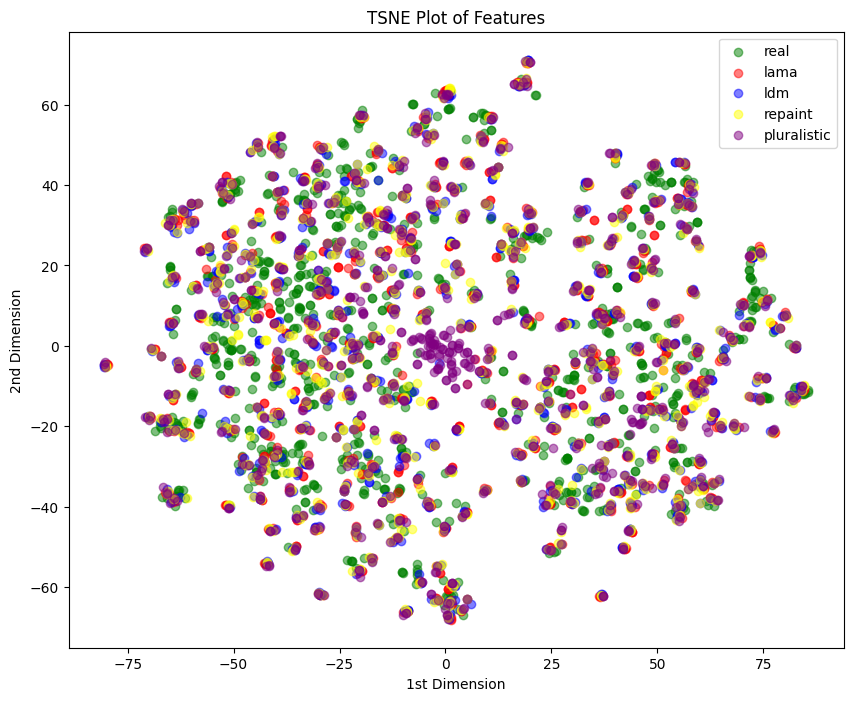

In [ ]:
clip_results = train_clip(
    dataloaders = loaders['clip'],
    num_classes = 5,
    num_epochs = 2,
    lr = 1e-3
)

plot_tsne(clip_results['valid_features'], clip_results['valid_labels'])

In [ ]:
import os
# save models in drive/MyDrive/Proiect DeepLearning/Task-2/Third-Method
save_path = 'drive/MyDrive/Proiect DeepLearning/Task-2/Third-Method/clip_results.pth'
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Ensure the directory exists
torch.save(clip_results, save_path)
print(f"Results saved to: {save_path}")

Results saved to: drive/MyDrive/Proiect DeepLearning/Task-2/Third-Method/clip_results.pth


####SAM

In [12]:
class SamClassifier(nn.Module):
    """
    A classifier that uses a frozen SAM image encoder backbone
    and a trainable linear head for classification.
    """
    def __init__(self, image_encoder: nn.Module, num_classes: int):
        super().__init__()
        # Use the SAM image encoder as backbone (frozen elsewhere)
        self.backbone = image_encoder
        # Linear head: assume backbone outputs 256 channels after pooling
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        # Get image embeddings from SAM (shape: [B, 256, H, W])
        embeddings = self.backbone(x)
        # Global average pool over spatial dims -> [B, 256]
        pooled = embeddings.mean(dim=(2, 3))
        # Linear classification head
        return self.classifier(pooled)

In [13]:
def train_sam(
    dataloaders: dict,
    num_classes: int,
    num_epochs: int,
    lr: float,
    accumulation_steps: int,
    weight_decay: float,
    device: torch.device
):
  device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

  label_to_model = {
        0: 'real',
        1: 'lama',
        2: 'ldm',
        3: 'repaint',
        4: 'pluralistic'
  }

  results = {}

  # Load SAM ViT-B backbone with pretrained checkpoint
  # (Assumes checkpoint downloaded; see segment-anything README for download links&#8203;:contentReference[oaicite:3]{index=3}.)
  sam = sam_model_registry["vit_b"](checkpoint="/content/sam_vit_b_01ec64.pth")
  sam.eval()

  # Adapt backbone for 256x256 inputs
  # - Set image encoder expected size
  sam.image_encoder.img_size = 256

  # - Compute new grid dimensions
  patch_size = sam.image_encoder.patch_embed.proj.stride[0]  # typically 16
  new_grid = 256 // patch_size

  if getattr(sam.image_encoder, "pos_embed", None) is not None:
    pos_embed = sam.image_encoder.pos_embed  # shape [1, H_old, W_old, C]
    H_old, W_old = pos_embed.shape[1], pos_embed.shape[2]
    if (H_old != new_grid) or (W_old != new_grid):
        # Interpolate to new size
        pe = pos_embed.data.reshape(1, H_old, W_old, -1).permute(0, 3, 1, 2)  # -> [1, C, H_old, W_old]
        pe = F.interpolate(pe, size=(new_grid, new_grid), mode='bilinear', align_corners=False)
        pe = pe.permute(0, 2, 3, 1)  # -> [1, H_new, W_new, C]
        sam.image_encoder.pos_embed = nn.Parameter(pe)

  # Freeze SAM backbone parameters
  for param in sam.parameters():
      param.requires_grad = False

  # Initialize model (with frozen SAM image encoder)
  model = SamClassifier(sam.image_encoder, num_classes).to(device)
  model.backbone = sam.image_encoder  # reference frozen backbone
  # Ensure backbone stays frozen
  for param in model.backbone.parameters():
      param.requires_grad = False

  # Initialize model (with frozen SAM image encoder)
  model = SamClassifier(sam.image_encoder, num_classes).to(device)
  model.backbone = sam.image_encoder  # reference frozen backbone
  # Ensure backbone stays frozen
  for param in model.backbone.parameters():
      param.requires_grad = False

  # Loss and optimizer (only classifier parameters are trainable)
  criterion = nn.CrossEntropyLoss()
  optimizer = AdamW(model.classifier.parameters(), lr=lr, weight_decay=weight_decay)

  # Training
  train_label_cnts = []
  train_accs = []
  all_train_accs = []

  for epoch in range(1, num_epochs+1):
    train_label_cnts.append([0] * num_classes)
    train_accs.append([0] * num_classes)

    model.train()
    optimizer.zero_grad()
    running_loss = 0.0

    for i, (imgs, labels) in enumerate(dataloaders['train']):
      imgs, labels = imgs.to(device), labels.to(device)

      outputs = model(imgs)
      loss = criterion(outputs, labels)
      running_loss += loss.item() * imgs.size(0)
      (loss / accumulation_steps).backward()

      # Gradient accumulation step
      if (i % accumulation_steps == 0) or (i == len(train_loader)):
          optimizer.step()
          optimizer.zero_grad()

      preds = outputs.argmax(dim=1)
      for pred, label in zip(preds, labels):
        train_label_cnts[-1][label] +=1
        if pred == label:
          train_accs[-1][label] += 1

    avg_loss = running_loss / len(dataloaders['train'].dataset)
    print(f"  Epoch {epoch}/{num_epochs} — head loss: {avg_loss:.4f}")

    train_acc = sum(train_accs[-1]) / sum(train_label_cnts[-1])
    all_train_accs.append(train_acc)
    print(f" ▶ train acc {train_acc:.4%}")

    for label in range(num_classes):
      if train_label_cnts[-1][label] != 0:
        train_acc = train_accs[-1][label] / train_label_cnts[-1][label]
      else:
        tain_acc = 0;
      print(f"   ▶ train acc {label_to_model[label]} {train_acc:.4%}")

  # validation
  model.eval()
  correct = total = 0

  valid_label_cnts = [0] * num_classes
  valid_accs = [0] * num_classes

  valid_features = []
  valid_labels = []

  with torch.no_grad():
    for imgs, labels in dataloaders['valid']:
      imgs, labels = imgs.to(device), labels.to(device)
      preds = model(imgs).argmax(dim=1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

      for pred, label in zip(preds, labels):
        valid_label_cnts[label] += 1
        if pred == label:
          valid_accs[label] += 1

      features = sam.image_encoder(imgs)  # [B, C, H, W]

      pooled_features = features.mean(dim=[2, 3])  # [B, C]

      valid_features.append(pooled_features.cpu())
      valid_labels.append(labels.cpu())

  valid_features = torch.cat(valid_features, dim=0).numpy()
  valid_labels = torch.cat(valid_labels, dim=0).numpy()

  valid_acc = correct / total
  print(f" ▶ valid acc {valid_acc:.4%}")

  for label in range(num_classes):
    if valid_label_cnts[label] != 0:
      valid_acc = valid_accs[label] / valid_label_cnts[label]
    else:
      valid_acc = 0
    print(f"   ▶ valid acc {label_to_model[label]} {valid_acc:.4%}")


  results = {
      'head': model,
      'valid_acc': valid_acc,

      'all_train_acc': all_train_accs[-1],

      'valid_features': valid_features,
      'valid_labels': valid_labels
  }

  for label in range(num_classes):
    if train_label_cnts[-1][label] != 0:
      results[f'train_acc_{label_to_model[label]}'] = train_accs[-1][label] / train_label_cnts[-1][label]
    else:
      results[f'train_acc_{label_to_model[label]}'] = 0

    if valid_label_cnts[label] != 0:
      results[f'valid_acc_{label_to_model[label]}'] = valid_accs[label] / valid_label_cnts[label]
    else:
      results[f'valid_acc_{label_to_model[label]}'] = 0

  # clear GPU memory
  torch.cuda.empty_cache()

  return results

In [14]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O /content/sam_vit_b_01ec64.pth


--2025-04-29 12:26:08--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.102, 108.157.254.15, 108.157.254.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘/content/sam_vit_b_01ec64.pth’

/content/sam_vit_b_ 100%[===================>] 357.67M   251MB/s    in 1.4s    

2025-04-29 12:26:09 (251 MB/s) - ‘/content/sam_vit_b_01ec64.pth’ saved [375042383/375042383]



  Epoch 1/2 — head loss: 1.5466
 ▶ train acc 35.9097%
   ▶ train acc real 28.1111%
   ▶ train acc lama 69.6222%
   ▶ train acc ldm 38.5222%
   ▶ train acc repaint 15.8240%
   ▶ train acc pluralistic 27.4667%
  Epoch 2/2 — head loss: 1.4565
 ▶ train acc 44.5877%
   ▶ train acc real 31.5333%
   ▶ train acc lama 89.6667%
   ▶ train acc ldm 58.3444%
   ▶ train acc repaint 14.7794%
   ▶ train acc pluralistic 28.6111%
 ▶ valid acc 43.6444%
   ▶ valid acc real 26.5556%
   ▶ valid acc lama 88.7778%
   ▶ valid acc ldm 43.5556%
   ▶ valid acc repaint 3.0000%
   ▶ valid acc pluralistic 56.3333%


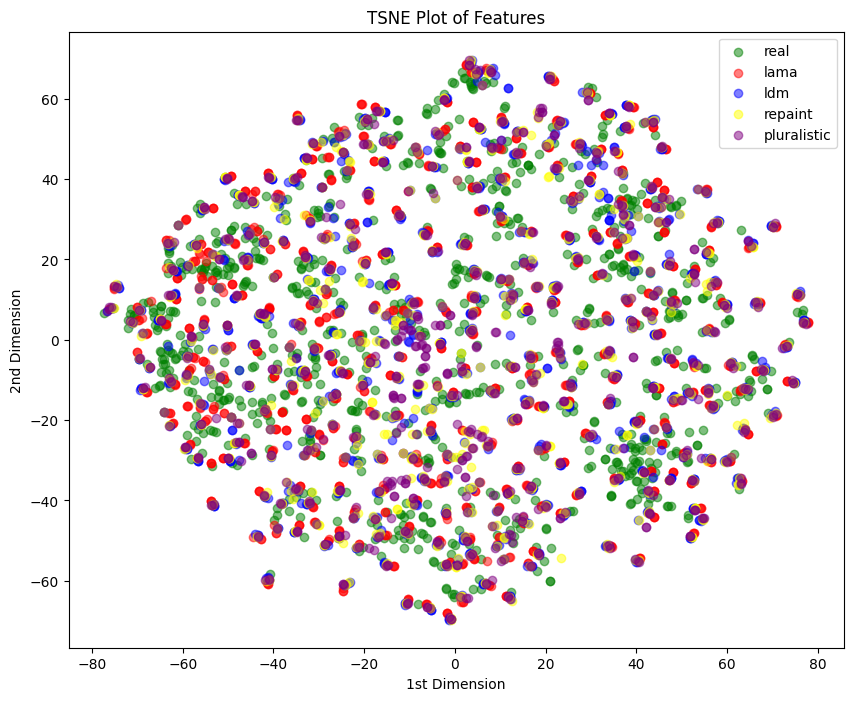

In [18]:
sam_results = train_sam(
    dataloaders = loaders['sam'],
    num_classes = 5,
    num_epochs = 2,
    lr = 1e-3,
    accumulation_steps = 1,
    weight_decay = 0.01,
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

plot_tsne(sam_results['valid_features'], sam_results['valid_labels'])

In [19]:
import os
# save models in drive/MyDrive/Proiect DeepLearning/Task-2/Third-Method
save_path = 'drive/MyDrive/Proiect DeepLearning/Task-2/Third-Method/sam_results.pth'
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Ensure the directory exists
torch.save(sam_results, save_path)
print(f"Results saved to: {save_path}")

Results saved to: drive/MyDrive/Proiect DeepLearning/Task-2/Third-Method/sam_results.pth
